# Scaffold Elaboration with DEVELOP

The purpose of this notebook is to demonstrate a simple, automated, end-to-end workflow for using DEVELOP.

In this notebook, we will explore how DEVELOP [[Link]](https://www.biorxiv.org/content/10.1101/2021.04.27.441676v1) can be used to perform scaffold elaboration. To demonstrate this, we will use the case study used in our paper describing DEVELOP. 

Disclaimer: Please note we make no claims about the suitability of the example nor the generated molecules in this example.

Any questions, comments or feedback, please email deane@stats.ox.ac.uk

### Basic settings

In [1]:
# How many cores for multiprocessing
n_cores = 1

# Google Colab Instructions

If you would like to test DEVELOP without local installation, you can use Google Colab for free!

If you are running this locally, you should not run the cells in this section. They are solely to setup Colab to use DEVELOP.

In [ ]:
# Clone repo in Colab
!git clone https://github.com/fimrie/DEVELOP/
# Enter repo
%cd DEVELOP

Cloning into 'DEVELOP'...
remote: Enumerating objects: 2105, done.
remote: Counting objects: 100% (2105/2105), done.
remote: Compressing objects: 100% (1787/1787), done.
remote: Total 2105 (delta 169), reused 2102 (delta 166), pack-reused 0
Receiving objects: 100% (2105/2105), 43.98 MiB | 22.30 MiB/s, done.
Resolving deltas: 100% (169/169), done.
/content/DEVELOP
/content/DEVELOP/examples


In [4]:
# Use Tensorflow 1.x
%tensorflow_version 1.x

import tensorflow as tf 
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [5]:
# Install packages

# Molgrid
!pip install molgrid

# RDKit
!pip install rdkit-pypi

     |████████████████████████████████| 30.2 MB 23 kB/s 
     |████████████████████████████████| 19.7 MB 1.3 MB/s 


# Imports

In [6]:
# If on Colab (otherwise likely in examples directory already)
%cd examples

import sys
sys.path.append("../")
sys.path.append("../analysis")

/content/drive/MyDrive/DEVELOP/examples


In [7]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolDrawing, DrawingOptions
from rdkit.Chem import MolStandardize

import numpy as np

from itertools import product
from joblib import Parallel, delayed
import re
from collections import defaultdict

from IPython.display import clear_output
IPythonConsole.ipython_useSVG = True

import DEVELOP
from DEVELOP import DenseGGNNChemModel
import frag_utils
import rdkit_conf_parallel
import example_utils

In [9]:
import data.prepare_data_scaffold_elaboration
from data.prepare_data_scaffold_elaboration import read_file, preprocess

# Load starting molecule and design example

Here, we will use the structure of a highly potent menin-MLL inhibitor designed by [Borkin et al.](https://pubs.acs.org/doi/10.1021/acs.jmedchem.5b01305). 

To design this compound, they performed structure-based optimization of a previously discovered inhibitor (PDB ID: 4X5Z), testing a number of substituents to the indole ring. One of their most promising designs involved the addition of a 4-methylpyrazole elaboration to the indole ring (PDB ID: 5DB3).

We demonstrate the ability of DEVELOP to recover this design, together with other similar compounds. 

In [13]:
scaff_path = './5db3_ligand.sdf'

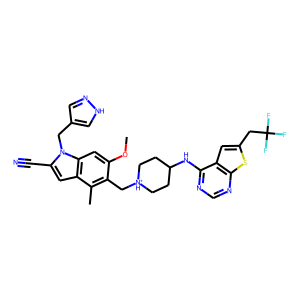

In [14]:
scaff_sdf = Chem.SDMolSupplier(scaff_path)
scaff_smi = Chem.MolToSmiles(scaff_sdf[0])

img = Draw.MolsToGridImage([Chem.MolFromSmiles(scaff_smi)], molsPerRow=1, subImgSize=(300, 300))
img

We'll now preprocess this into a format where it can be elaborated with DEVELOP.

To do so, we'll first need to decide the core we want to elaborate from and add an exit vector.

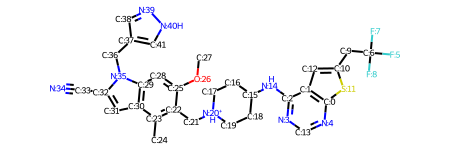

In [15]:
starting_point_2d = Chem.Mol(scaff_sdf[0])
_ = AllChem.Compute2DCoords(starting_point_2d)
example_utils.mol_with_atom_index(starting_point_2d)

We need to select which pairs of atoms we want to break to construct the exit vector. Let's do this, and then view the new molecule.

In [16]:
atom_pair_idx_1 = [35, 36]

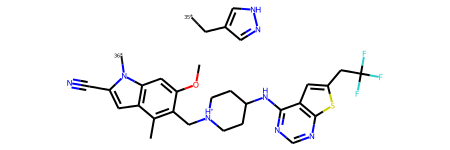

In [17]:
bonds_to_break = [starting_point_2d.GetBondBetweenAtoms(x,y).GetIdx() for x,y in [atom_pair_idx_1]]

fragmented_mol = Chem.FragmentOnBonds(starting_point_2d, bonds_to_break)
_ = AllChem.Compute2DCoords(fragmented_mol)
fragmented_mol

In [18]:
print(Chem.MolToSmiles(fragmented_mol))

[35*]Cc1cn[nH]c1.[36*]n1c(C#N)cc2c(C)c(C[NH+]3CCC(Nc4ncnc5sc(CC(F)(F)F)cc45)CC3)c(OC)cc21


In [19]:
# Split fragmentation into core scaffold and elaboration
fragmentation = Chem.MolToSmiles(fragmented_mol).split('.')
elaboration = fragmentation[0]
scaffold = fragmentation[1]

elaboration = re.sub('[0-9]+\*', '*', elaboration)
scaffold = re.sub('[0-9]+\*', '*', scaffold)

# Prepare example as input data

We now need to prepare the pharmacophoric information, and preprocess this example into the form required by DEVELOP.

In [20]:
# Write data to file
data_path = "./scaffold_elaboration_test_data.txt"
with open(data_path, 'w') as f:
    f.write("%s %s %s" % (scaff_smi, elaboration, scaffold))

In [21]:
raw_data = read_file(data_path, add_idx=True, calc_pharm_counts=True)
preprocess(raw_data, "zinc", "scaffold_elaboration_test", "./", False)

Finished reading: 1 / 1
Parsing smiles as graphs.
Processed: 1 / 1
Saving data
Length raw data: 	1
Length processed data: 	1


In [22]:
# Calculate Pharmacophoric information
core_path = 'scaffold_elaboration_core.sdf'
pharmacophores_path = 'scaffold_elaboration_pharmacophores.sdf'
fragmentations_pharm, fails = frag_utils.create_frags_pharma_sdf_dataset([[scaff_smi, elaboration, scaffold, 0, 0]], 
                                                                         scaff_path, dataset="CASF",
                                                                         sdffile=core_path,
                                                                         sdffile_pharm=pharmacophores_path,
                                                                         prot="", verbose=True)

Done


In [23]:
# Write .types file
with open("scaffold_elaboration_example.types", 'w') as f:
  f.write('1 ' + core_path + ' ' + pharmacophores_path)

# Load DEVELOP model and generate new molecules

Let's now setup and generate molecules with DEVELOP. The below settings will generate 100 molecules for each length of linker from nine to ten atoms, inclusively.

In [25]:
# Arguments for DEVELOP
args = defaultdict(None)
args['--dataset'] = 'zinc'
args['--config'] = '{"generation": true, \
                     "batch_size": 1, \
                     "number_of_generation_per_valid": 250, \
                     "train_file": "./molecules_scaffold_elaboration_test.json", \
                     "valid_file": "./molecules_scaffold_elaboration_test.json", \
                     "train_struct_file": "./scaffold_elaboration_example.types", \
                     "valid_struct_file": "./scaffold_elaboration_example.types", \
                     "struct_data_root": "./", \
                     "output_name": "DEVELOP_scaffold_elaboration_example_gen.smi"}'
args['--freeze-graph-model'] = False
args['--restore'] = '../models/scaffold_elaboration/pretrained_DEVELOP_model.pickle'

In [26]:
# Setup model and generate molecules
model = DenseGGNNChemModel(args)
model.train()
# Free up some memory
model = ''

Run 2021-09-30-18-23-21_77 starting with following parameters:
{"task_sample_ratios": {}, "use_edge_bias": true, "clamp_gradient_norm": 1.0, "out_layer_dropout_keep_prob": 1.0, "tie_fwd_bkwd": true, "random_seed": 0, "batch_size": 1, "prior_learning_rate": 0.05, "stop_criterion": 0.01, "num_epochs": 10, "epoch_to_generate": 10, "number_of_generation_per_valid": 250, "maximum_distance": 50, "use_argmax_generation": false, "residual_connection_on": true, "residual_connections": {"2": [0], "4": [0, 2], "6": [0, 2, 4], "8": [0, 2, 4, 6], "10": [0, 2, 4, 6, 8], "12": [0, 2, 4, 6, 8, 10], "14": [0, 2, 4, 6, 8, 10, 12]}, "num_timesteps": 7, "hidden_size": 32, "encoding_size": 4, "kl_trade_off_lambda": 0.3, "learning_rate": 0.001, "graph_state_dropout_keep_prob": 1, "compensate_num": 0, "train_file": "./molecules_scaffold_elaboration_test.json", "valid_file": "./molecules_scaffold_elaboration_test.json", "train_struct_file": "./scaffold_elaboration_example.types", "valid_struct_file": "./scaff

# Assess generated molecules

Let's calculate some 2D and 3D properties of the generated molecules. We follow the same procedure to filter/score the molecules as described in our paper describing DEVELOP.

In [27]:
# Load molecules
generated_smiles = frag_utils.read_triples_file("./DEVELOP_scaffold_elaboration_example_gen.smi")

in_mols = [smi[1] for smi in generated_smiles]
frag_mols = [smi[0] for smi in generated_smiles]
gen_mols = [smi[2] for smi in generated_smiles]

du = Chem.MolFromSmiles('*')
clean_frags = [Chem.MolToSmiles(Chem.RemoveHs(AllChem.ReplaceSubstructs(Chem.MolFromSmiles(smi),du,Chem.MolFromSmiles('[H]'),True)[0])) for smi in frag_mols]

clear_output(wait=True)
print("Done")

Done


## 2D analysis


In [28]:
# Check valid
results = []
for in_mol, frag_mol, gen_mol, clean_frag in zip(in_mols, frag_mols, gen_mols, clean_frags):
    if len(Chem.MolFromSmiles(gen_mol).GetSubstructMatch(Chem.MolFromSmiles(clean_frag)))>0:
        results.append([in_mol, frag_mol, gen_mol, clean_frag, gen_mol])

print("Number of generated SMILES: \t%d" % len(generated_smiles))
print("Number of valid SMILES: \t%d" % len(results))
print("%% Valid: \t\t\t%.2f%%" % (len(results)/len(generated_smiles)*100))

Number of generated SMILES: 	250
Number of valid SMILES: 	250
% Valid: 			100.00%


In [29]:
# Create dictionary of results
results_dict = {}
for res in results:
    if res[0]+'.'+res[1] in results_dict: # Unique identifier - starting fragments and original molecule
        results_dict[res[0]+'.'+res[1]].append(tuple(res))
    else:
        results_dict[res[0]+'.'+res[1]] = [tuple(res)]

In [30]:
# Check uniqueness
print("Unique molecules: %.2f%%" % (frag_utils.unique(results_dict.values())*100))

Unique molecules: 49.60%


In [31]:
# Check if molecules pass 2D filters 
filters_2d = frag_utils.calc_filters_2d_dataset(results, pains_smarts_loc="../analysis/wehi_pains.csv", n_cores=n_cores)

results_filt = []
for res, filt in zip(results, filters_2d):
    if filt[0] and filt[1] and filt[2]:
        results_filt.append(res)
        
clear_output(wait=True)        
print("Pass all 2D filters: \t\t\t\t%.2f%%" % (len(results_filt)/len(results)*100))
print("Valid and pass all 2D filters: \t\t\t%.2f%%" % (len(results_filt)/len(generated_smiles)*100))
print("Pass synthetic accessibility (SA) filter: \t%.2f%%" % (len([f for f in filters_2d if f[0]])/len(filters_2d)*100))
print("Pass ring aromaticity filter: \t\t\t%.2f%%" % (len([f for f in filters_2d if f[1]])/len(filters_2d)*100))
print("Pass SA and ring filters: \t\t\t%.2f%%" % (len([f for f in filters_2d if f[0] and f[1]])/len(filters_2d)*100))
print("Pass PAINS filters: \t\t\t\t%.2f%%" % (len([f for f in filters_2d if f[2]])/len(filters_2d)*100))

Pass all 2D filters: 				44.00%
Valid and pass all 2D filters: 			44.00%
Pass synthetic accessibility (SA) filter: 	44.00%
Pass ring aromaticity filter: 			95.60%
Pass SA and ring filters: 			44.00%
Pass PAINS filters: 				88.40%


In [32]:
# Get unique molecules
print("Number molecules passing 2D filters:\t\t%d" % len(results_filt))
results_filt_unique = example_utils.unique_mols(results_filt)
print("Number unique molecules passing 2D filters:\t%d" % len(results_filt_unique))

Number molecules passing 2D filters:		110
Number unique molecules passing 2D filters:	55


## View most similar molecules

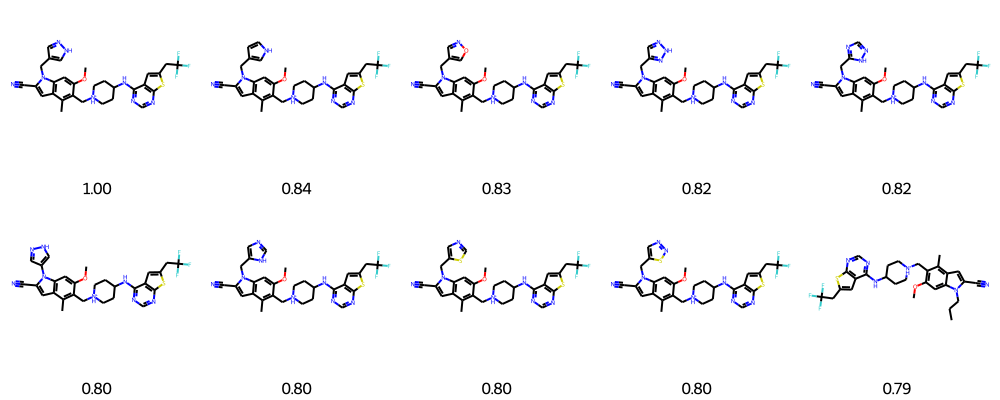

In [33]:
from rdkit.Chem import DataStructs

# Calculate Tanimoto similarity of Morgan fingerprints (radius 2, 2048 bits)
smis = [res[2] for res in results_filt_unique]
gen_fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), 2, 2048) for smi in smis]
orig_fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(in_mols[0]), 2, 2048)

gen_sims = [DataStructs.TanimotoSimilarity(orig_fp, gen_fp) for gen_fp in gen_fps]

best_mols = sorted(list(zip(smis, gen_sims)), key=lambda x: x[1], reverse=True)[:10]

mols = [Chem.MolFromSmiles(m[0]) for m in best_mols]

img = Draw.MolsToGridImage(mols,
                     molsPerRow=5, legends=["%.2f" % m[1] for m in best_mols],
                    )
img